###### December 2019 - Roger Melko

Diagonalizing the Hamiltonian matrix for the transverse field Ising model to find the energy eigenvalues and eigenkets.   Calculate the groundstate magnetization.

We will use the same Hamiltonian convention as the QMC program:
$$
H = -J\sum_{\langle i j \rangle} \sigma^z_i \sigma^z_j - B \sum_i \sigma^x_i
$$
where ${\bf \sigma}_i$ are Pauli operators.  In this convention, the 1+1 CFT is at $h/J = 1$.

In [1]:
using LinearAlgebra

In [2]:
N = 6
Dim = 2^N

J = 1. #this is the exchange
B = 1. #this is the transverse field

Hamiltonian = zeros(Dim,Dim)   #This is your 2D Hamiltonian matrix

for Ket = 0:Dim-1  #Loop over Hilbert Space
    Diagonal = 0.
    for SpinIndex = 0:N-2  #Loop over spin index (base zero, stop one spin before the end of the chain)
        Spin1 = 2*((Ket>>SpinIndex)&1) - 1
        NextIndex = SpinIndex + 1
        Spin2 = 2*((Ket>>NextIndex)&1) - 1
        Diagonal = Diagonal - J*Spin1*Spin2 #spins are +1 and -1
    end
    Hamiltonian[Ket+1,Ket+1] = Diagonal
    
    for SpinIndex = 0:N-1
        bit = 2^SpinIndex   #The "label" of the bit to be flipped
        Bra = Ket ⊻ bit    #Binary XOR flips the bit
        Hamiltonian[Bra+1,Ket+1] = -B
    end
end
Hamiltonian = Hermitian(Hamiltonian);

In the Julia LinearAlgebra package, the eigen function finds eigenvalues and eigenvectors.  They are ordered; i.e. the groundstate energy corresponds to index 1

In [3]:
Diag = eigen(Hamiltonian);

In [4]:
GroundState = Diag.vectors[:, 1];  #this gives the groundstate eigenvector
Diag.values[1] / N

-1.2160383017597922

In [5]:
##### Calculate the groundstate magnetization <m^2> in the Z direction
magnetization = zeros(Dim)
abs_mag = zeros(Dim)
mag_squared = zeros(Dim)

SumSz = dropdims(sum(@. (2 * (((0:Dim-1) >> (0:N-1)') & 1) - 1); dims=2); dims=2)
AbsSumSz = abs.(SumSz)
SumSzSq = abs2.(SumSz)

magnetization = SumSz' * abs2.(Diag.vectors)
abs_mag = AbsSumSz' * abs2.(Diag.vectors)
mag_squared = SumSzSq' * abs2.(Diag.vectors)

(magnetization[1] / N), (abs_mag[1] / N), (mag_squared[1] / (N*N))

(-2.220446049250313e-15, 0.606253962127837, 0.4824376202801901)

In [6]:
beta_vals = [20,15,10,5,3,2,1,0.8,0.5,0.2]
ED =zeros(Float64,length(beta_vals))
idx = 1
for β in beta_vals
    weights = exp.(-β * Diag.values)
    Z = sum(weights)
    E = dot(Diag.values, weights) / (N*Z)
    # magnetization of thermal state
    M = dot(weights, magnetization) / (N*Z)
    M_abs = dot(weights, abs_mag) / (N*Z)
    M2 = dot(weights, mag_squared) / (N*N*Z)
    println(β," ",E," ",M," ",M_abs," ",M2)
    #ED[idx,1] = β
    ED[idx,1] = M2
    idx += 1
end

20.0 -1.2160330882932437 -2.221663343439044e-15 0.6062678612242303 0.4824533210158827
15.0 -1.2159802506899193 -2.2340003817455894e-15 0.6064087256623759 0.4826124447073306
10.0 -1.2153960315748102 -2.3703700092831754e-15 0.6079655775028946 0.48437111888769074
5.0 -1.2092191860845227 -3.761987277120345e-15 0.6236092464663598 0.5020679898280522
3.0 -1.1969216436112338 -5.6909564346668226e-15 0.6420203586364335 0.5233219205987816
2.0 -1.1747706424079856 -6.812999257023217e-15 0.6432705416399168 0.5261570463628659
1.0 -1.0504324129922504 -5.970570185874674e-15 0.5829791977360822 0.4599291425676826
0.8 -0.97090582150502 -5.043086241641171e-15 0.5489314093266392 0.4206694705645438
0.5 -0.7523829662333137 -3.0771347831752976e-15 0.47495187706041714 0.3351586947048173
0.2 -0.3535501176598673 -1.1705068040531128e-15 0.37838823200409183 0.22983028398430716


In [7]:
#These are values of M2 obtained by running the QMC
#MCS = 300,000
QMC = [ 0.48264 ; 
        0.48245 ;
        0.48375 ;
        0.50048 ;
        0.52023 ;
        0.52627 ;
        0.45904 ;
        0.41997 ;
        0.33552 ;
        0.23106
]

10-element Array{Float64,1}:
 0.48264
 0.48245
 0.48375
 0.50048
 0.52023
 0.52627
 0.45904
 0.41997
 0.33552
 0.23106

In [8]:
using Plots

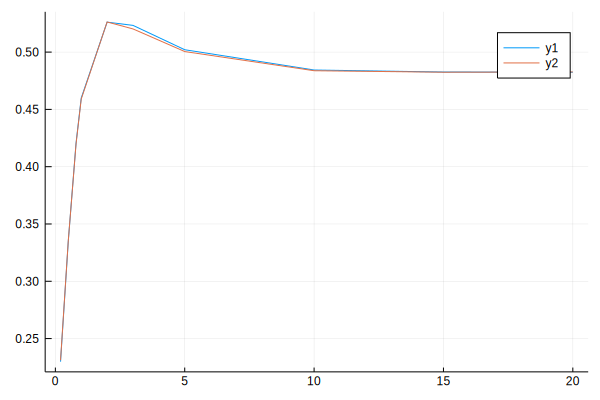

In [10]:
plot(beta_vals,ED)
plot!(beta_vals,QMC)